In [1]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/idim-debug-spectra/notebooks')
#notebook_dir = Path().absolute()
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

from abc import ABC, abstractmethod
import h5py
import numpy as np
from typing import Dict, List, Optional, Tuple, Any, Union
from pathlib import Path
from scipy import stats
from dataclasses import dataclass
from src.utils._config import *
from src.utils._io import *
from src.utils.plot import *
from src.utils.binning import *
from src.spectra._definition import *
from src.idm._definition import *
import argparse
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import os
HOME_DIR = Path("/data/chan21/idim-debug-spectra/")

In [2]:
# IDM visualization
from matplotlib.colors import LinearSegmentedColormap
def save_matrix(matrix, filename='matrix.svg', style='nature'):
    """Save matrix as clean SVG without margins."""
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # Nature-style colormap options
    if style == 'redblue':
        # Red-Blue diverging (common in Nature papers)
        cmap = LinearSegmentedColormap.from_list('nature_rb', 
            ['#3B4992', '#FFFFFF', '#EE0000'])
    elif style == 'coolwarm':
        # More subtle red-blue diverging
        cmap = 'RdBu_r'
    elif style == 'purpleorange':
        cmap = 'PuOr'
    else:
        # Single-color gradient (blue)
        cmap = LinearSegmentedColormap.from_list('nature_blue',
            ['#FFFFFF', '#2B5A9B'])
    
    ax.imshow(matrix, cmap=cmap, vmax=1, vmin=-1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

def zscore_matrix(matrix):
    """Z-score matrix."""
    return (matrix - np.mean(matrix)) / np.std(matrix)

    
def triu_to_matrix(flat_vals, n):
    """Convert flattened upper triangle to symmetric matrix."""
    matrix = np.zeros((n, n))
    triu_idx = np.triu_indices_from(matrix, k=1)
    matrix[triu_idx] = flat_vals
    matrix = matrix + matrix.T
    np.fill_diagonal(matrix, 1.0)
    return matrix

In [3]:
movies = ['iteration', 'defeat', 'growth', 'lemonade']
rois = ['occipital', 'ventral', 'temporal', 'semantic', 'pmc']
# rois_names = {'occipital': 'OccC',
#             'ventral': 'VTC',
#             'temporal': 'LTC',
#             'semantic': 'SMC'}
rois_names = {'occipital': 'early',
            'ventral': 'ventral',
            'temporal': 'lateral',
            'semantic': 'temporoparietal',
            'pmc': 'posteromedial'}
behavioral_isc = {roi: [] for roi in rois}
behavioral = {roi: [] for roi in rois}
behavioral_anat = {}
#bootstrapped_isc = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
#bootstrapped = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
permuted_isc = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
permuted = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
permuted_anat = {}
significance_isc = {roi: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for roi in rois}
significance = {roi: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for roi in rois}
significance_movie_isc = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
significance_movie = {roi: {movie: {slices: [] for slices in [(0, 10), (10, 100), (100, None)]} for movie in movies} for roi in rois}
significance_anat = {}

In [4]:
rank_slices = [(0, 10), (10, 100), (100, None)]
embs = pickle.load(open('/home/chan21/_individual_dim/results/embs.pkl', 'rb'))
def create_use_rdm(embs, movie):
    capitalized_movie = movie.capitalize()
    vector = embs[capitalized_movie]
    use_rdm = cosine_similarity(vector, vector)
    return use_rdm

def compute_idm(args, anat=False):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )

    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path
    print(h5_data_path)
    
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})

    if anat:
        corrs = {movie: [] for movie in movies}
        for movie in movies:
            x = get_upper_triangle(create_use_rdm(embs, movie))
            y = get_upper_triangle(anat_matrices[movie])
            corr = stats.spearmanr(x, y)[0]
            corrs[movie].append(corr)
        return corrs

    idm_series = {}
    corrs_series = {movie: {slice: [] for slice in rank_slices} for movie in movies}
    with h5py.File(h5_data_path, 'r') as h5f:
        # Initialize array to store all spectra    
        for movie in movies:
            all_spectra = np.zeros((n_subjects, n_subjects, len(rank_slices)))
            # Load spectra for each subject pair
            for i, i_subject in enumerate(subjects):
                for j, j_subject in enumerate(subjects[i+1:], i+1):
                    spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:]
        
                    for s, slices in enumerate(rank_slices):
                        all_spectra[i, j, s] = spectrum[slices[0]:slices[1]].mean() if slices[1] is not None else spectrum[slices[0]:].mean()
                        all_spectra[j, i, s] = all_spectra[i, j, s]
            idm_series[movie] = all_spectra
             # Visualization
            # if movie == 'iteration':
            #     idm_0 = -zscore_matrix(idm_series[movie][:, :, 0])
            #     idm_1 = -zscore_matrix(idm_series[movie][:, :, 1])
            #     idm_2 = -zscore_matrix(idm_series[movie][:, :, 2])
            #     save_matrix(idm_0, filename=f"idm_iteration_1.svg", style='coolwarm')
            #     save_matrix(idm_1, filename=f"idm_iteration_10.svg", style='coolwarm')
            #     save_matrix(idm_2, filename=f"idm_iteration_100.svg", style='coolwarm')
            #     break
            
    bin_strategy = None
    analysis = IDMAnalysis(cache, bin_strategy)

    for m, movie in enumerate(movies):
        idm_series[movie] = np.moveaxis(idm_series[movie], -1, 0)
        rdm = create_use_rdm(embs, movie)
        y = get_upper_triangle(rdm) 
        if type(args.motion_type) == list:
            z1 = get_upper_triangle(motion_matrices[0][movie])
            z2 = get_upper_triangle(motion_matrices[1][movie])
            if args.isc:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(idm_series[movie][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    _, rx, ry = analysis._partial_correlation(rx, ry, z2)
                    corrs, _, _ = analysis._partial_correlation(rx, ry, get_upper_triangle(anat_matrices[movie]))
                    #anat_normalized = anat_matrices[movie] - motion_matrices[movie]
                    #corrs, _, _ = analysis.compute_correlation_series(x, y, anat_normalized)
                    corrs_series[movie][slices].append(float(corrs))
            else:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(idm_series[movie][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    corrs, rx, ry = analysis._partial_correlation(rx, ry, z2)
                    corrs_series[movie][slices].append(float(corrs))
        else:
            if args.isc:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(idm_series[movie][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    corrs, _, _ = analysis._partial_correlation(rx, ry, get_upper_triangle(anat_matrices[movie]))
                    #anat_normalized = anat_matrices[movie] - motion_matrices[movie]
                    #corrs, _, _ = analysis.compute_correlation_series(x, y, anat_normalized)
                    corrs_series[movie][slices].append(float(corrs))
            else:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(idm_series[movie][i])
                    corrs, _, _ = analysis._partial_correlation(x, y, z1)
                    corrs_series[movie][slices].append(float(corrs))
    return corrs_series



2025-04-03 10:09:11.654746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 10:09:12.410985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-04-03 10:09:13.147687: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


- Permute IDMs

In [5]:

def permute_idm(args, n_permutations=10):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})

    bin_strategy = None
    analysis = IDMAnalysis(cache, bin_strategy)

    permuted_series = {movie: [] for movie in movies}
    with h5py.File(h5_data_path, 'r') as h5f:
        for p in tqdm(range(n_permutations)):
            for movie in movies:
                all_spectra = np.zeros((n_subjects, n_subjects, len(rank_slices)))
                perm_i = np.random.permutation(subjects)
                perm_j = np.random.permutation(subjects)
                for i, i_subject in enumerate(perm_i):
                    for j, j_subject in enumerate(perm_j):
                        if i_subject != j_subject:
                            try:
                                spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:]
                            except:
                                spectrum = h5f[f"data/{j_subject}_{i_subject}_{movie}"]["observed"][:]
                            for s, slices in enumerate(rank_slices):
                                all_spectra[i, j, s] = spectrum[slices[0]:slices[1]].mean() if slices[1] is not None else spectrum[slices[0]:].mean()
                                all_spectra[j, i, s] = all_spectra[i, j, s]
                permuted_series[movie].append(np.moveaxis(all_spectra, -1, 0))
    
    perm_corrs = []

    for p in tqdm(range(n_permutations)):
        corrs_series = {movie: {slice: [] for slice in rank_slices} for movie in movies}
        for m, movie in enumerate(movies):
            z1 = get_upper_triangle(motion_matrices[0][movie])
            z2 = get_upper_triangle(motion_matrices[1][movie])
            y = get_upper_triangle(create_use_rdm(embs, movie))
            if args.isc:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(permuted_series[movie][p][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    _, rx, ry = analysis._partial_correlation(rx, ry, z2)
                    corrs, _, _ = analysis._partial_correlation(rx, ry, get_upper_triangle(anat_matrices[movie]))
                    corrs_series[movie][slices].append(corrs)
            else:
                for i, slices in enumerate(rank_slices):
                    x = get_upper_triangle(permuted_series[movie][p][i])
                    _, rx, ry = analysis._partial_correlation(x, y, z1)
                    corrs, rx, ry = analysis._partial_correlation(rx, ry, z2)
                    corrs_series[movie][slices].append(float(corrs))
        perm_corrs.append(corrs_series)
    return perm_corrs


def permute_anat(args, n_permutations=10):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})

    bin_strategy = None
    analysis = IDMAnalysis(cache, bin_strategy)

    rdms = {}
    for m, movie in enumerate(movies):
        rdm = create_use_rdm(embs, movie)
        rdms[movie] = rdm
    
    perm_corrs = {movie: [] for movie in movies}   
    for p in tqdm(range(n_permutations)):
        np.random.seed(p)
        permuted_series = {movie: np.zeros((n_subjects, n_subjects)) for movie in movies}
        for movie in movies:
            perm_i = np.random.permutation(subjects)
            perm_j = np.random.permutation(subjects)
            # shuffle rdms[movie]
            for i, i_subject in enumerate(perm_i):
                for j, j_subject in enumerate(perm_j):
                    if i_subject != j_subject:
                        permuted_series[movie][i, j] = anat_matrices[movie][config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        permuted_series[movie][j, i] = permuted_series[movie][i, j]
            x = get_upper_triangle(permuted_series[movie])
            y = get_upper_triangle(rdms[movie])
            z1 = get_upper_triangle(motion_matrices[0][movie])
            z2 = get_upper_triangle(motion_matrices[1][movie])
            if type(args.motion_type) == list:
                _, rx, ry = analysis._partial_correlation(x, y, z1)
                corrs, _, _ = analysis._partial_correlation(rx, ry, z2)
                perm_corrs[movie].append(float(corrs))
            else:
                corrs, _, _ = analysis._partial_correlation(x, y, z1)
                perm_corrs[movie].append(float(corrs))
    return perm_corrs

In [6]:

for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=True,
        isc_dir=f"/home/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #"/data/chan21/indiv_diff_dim/results/n=39/isc_occipital_functional/eigenspectra.h5",
        anatomical=False,
        #anatomical_dir="/path/to/anatomical_matrices"
    )
    corrs = compute_idm(args) #compute_idm(args, anat=True)
    print(f"behavioral_isc[{roi}]: {corrs}")
    behavioral_isc[roi] = corrs
    perm_corrs = permute_idm(args, n_permutations=1000)
    
    perm_movie = np.array([[[eigen[0] for eigen in eigen_data.values()] for eigen_data in perm_corr.values()] for perm_corr in perm_corrs]) # (n_permutations, 4, 3)
    perm_movie_mean = np.mean(perm_movie, axis=1) # (n_permutations, 3)
    for i, slices in enumerate([(0, 10), (10, 100), (100, None)]):
        permuted = perm_movie_mean[:, i]
        observed = np.mean([[movie_data[eigen][0] for eigen in movie_data.keys()] for movie_data in behavioral_isc[roi].values()], axis=0)
        p = np.sum(np.array(permuted) > observed[i]) / len(permuted)
        significance_isc[roi][slices] = p
        print(f"significance_isc[{rois_names[roi]}]: {slices} p={p}")

        for n_mov, movie in enumerate(behavioral_isc[roi].keys()):
            permuted = perm_movie[:, n_mov, i]
            observed = [eigen for eigen in behavioral_isc[roi][movie][slices]]
            p = np.sum(np.array(permuted) > observed) / len(permuted)
            significance_movie_isc[roi][movie][slices] = p
            print(f"significance_movie_isc[{rois_names[roi]}]: {movie} {slices} p={p}")

    corrs = compute_idm(args, anat=True)
    print(f"behavioral_anat[{roi}]: {corrs}")
    behavioral_anat[roi] = corrs
    
    perm_corrs = permute_anat(args, n_permutations=1000)
    permuted = np.mean([perm_corrs[movie] for movie in movies], axis=0)
    observed = np.mean([behavioral_anat[roi][movie] for movie in movies], axis=0)
    p = np.sum(np.array(permuted) > observed) / len(permuted)
    significance_anat[roi] = p
    print(f"significance_anat[{rois_names[roi]}]:  p={p}")

    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=False,
        isc_dir=f"/home/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #"/data/chan21/indiv_diff_dim/results/n=39/isc_occipital_functional/eigenspectra.h5",
        anatomical=False,
        #anatomical_dir="/path/to/anatomical_matrices"
    )

    corrs = compute_idm(args)
    print(f"behavioral[{roi}]: {corrs}")
    behavioral[roi] = corrs

    perm_corrs = permute_idm(args, n_permutations=1000)
    
    perm_movie = np.array([[[eigen[0] for eigen in eigen_data.values()] for eigen_data in perm_corr.values()] for perm_corr in perm_corrs]) # (n_permutations, 4, 3)
    perm_movie_mean = np.mean(perm_movie, axis=1) # (n_permutations, 3)
    for i, slices in enumerate([(0, 10), (10, 100), (100, None)]):
        permuted = perm_movie_mean[:, i]
        observed = np.mean([[movie_data[eigen][0] for eigen in movie_data.keys()] for movie_data in behavioral[roi].values()], axis=0)
        p = np.sum(np.array(permuted) > observed[i]) / len(permuted)
        significance[roi][slices] = p
        print(f"significance[{rois_names[roi]}]: {slices} p={p}")

        for n_mov, movie in enumerate(behavioral[roi].keys()):
            permuted = perm_movie[:, n_mov, i]
            observed = [eigen for eigen in behavioral[roi][movie][slices]]
            p = np.sum(np.array(permuted) > observed) / len(permuted)
            significance_movie[roi][movie][slices] = p
            print(f"significance[{rois_names[roi]}]: {movie} {slices} p={p}")


/data/chan21/idim-debug-spectra/results/cov_pmc_functional_perm/eigenspectra.h5
behavioral_isc[pmc]: {'iteration': {(0, 10): [0.17736134076911655], (10, 100): [0.11222227900444168], (100, None): [-0.012168808902141118]}, 'defeat': {(0, 10): [0.06410943776337272], (10, 100): [0.12835001197956883], (100, None): [0.06444543906430869]}, 'growth': {(0, 10): [0.17875040874744622], (10, 100): [0.1340966827617704], (100, None): [0.02974470258436401]}, 'lemonade': {(0, 10): [0.20090934229224336], (10, 100): [0.1578345053052384], (100, None): [-0.03281816280575803]}}


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


significance_isc[posteromedial]: (0, 10) p=0.0
significance_movie_isc[posteromedial]: iteration (0, 10) p=0.006
significance_movie_isc[posteromedial]: defeat (0, 10) p=0.224
significance_movie_isc[posteromedial]: growth (0, 10) p=0.01
significance_movie_isc[posteromedial]: lemonade (0, 10) p=0.004
significance_isc[posteromedial]: (10, 100) p=0.0
significance_movie_isc[posteromedial]: iteration (10, 100) p=0.02
significance_movie_isc[posteromedial]: defeat (10, 100) p=0.017
significance_movie_isc[posteromedial]: growth (10, 100) p=0.016
significance_movie_isc[posteromedial]: lemonade (10, 100) p=0.01
significance_isc[posteromedial]: (100, None) p=0.26
significance_movie_isc[posteromedial]: iteration (100, None) p=0.648
significance_movie_isc[posteromedial]: defeat (100, None) p=0.038
significance_movie_isc[posteromedial]: growth (100, None) p=0.234
significance_movie_isc[posteromedial]: lemonade (100, None) p=0.821
/data/chan21/idim-debug-spectra/results/cov_pmc_functional_perm/eigenspe

100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s]


significance_anat[posteromedial]:  p=0.0
/data/chan21/idim-debug-spectra/results/cov_pmc_functional_perm/eigenspectra.h5
behavioral[pmc]: {'iteration': {(0, 10): [0.27904544712004253], (10, 100): [0.16660312253875625], (100, None): [-0.011464648362121662]}, 'defeat': {(0, 10): [0.1175622166313827], (10, 100): [0.14187657450062102], (100, None): [0.06132940057244218]}, 'growth': {(0, 10): [0.22548025004534838], (10, 100): [0.1596576579430623], (100, None): [0.04287430692841256]}, 'lemonade': {(0, 10): [0.2775121791916385], (10, 100): [0.17290856947832328], (100, None): [-0.027577094592677785]}}


100%|██████████| 1000/1000 [04:45<00:00,  3.51it/s]

significance[posteromedial]: (0, 10) p=0.0
significance[posteromedial]: iteration (0, 10) p=0.0
significance[posteromedial]: defeat (0, 10) p=0.073
significance[posteromedial]: growth (0, 10) p=0.002
significance[posteromedial]: lemonade (0, 10) p=0.0
significance[posteromedial]: (10, 100) p=0.0
significance[posteromedial]: iteration (10, 100) p=0.001
significance[posteromedial]: defeat (10, 100) p=0.006
significance[posteromedial]: growth (10, 100) p=0.005
significance[posteromedial]: lemonade (10, 100) p=0.001
significance[posteromedial]: (100, None) p=0.178
significance[posteromedial]: iteration (100, None) p=0.601
significance[posteromedial]: defeat (100, None) p=0.043
significance[posteromedial]: growth (100, None) p=0.124
significance[posteromedial]: lemonade (100, None) p=0.767


In [6]:
# Save pmc behavioral, behavioral_isc, behavioral_anat, significance, significance_isc, significance_anat
# pickle.dump(behavioral, open('/home/chan21/idim-debug-spectra/results/behavioral_pmc.pkl', 'wb'))
# pickle.dump(behavioral_isc, open('/home/chan21/idim-debug-spectra/results/behavioral_isc_pmc.pkl', 'wb'))
# pickle.dump(behavioral_anat, open('/home/chan21/idim-debug-spectra/results/behavioral_anat_pmc.pkl', 'wb'))
# pickle.dump(significance, open('/home/chan21/idim-debug-spectra/results/significance_pmc.pkl', 'wb'))
# pickle.dump(significance_isc, open('/home/chan21/idim-debug-spectra/results/significance_isc_pmc.pkl', 'wb'))
# pickle.dump(significance_anat, open('/home/chan21/idim-debug-spectra/results/significance_anat_pmc.pkl', 'wb'))

# # Save behavioral, behavioral_isc, behavioral_anat, significance, significance_isc, significance_anat
# pickle.dump(behavioral, open('/home/chan21/idim-debug-spectra/results/behavioral.pkl', 'wb'))
# pickle.dump(behavioral_isc, open('/home/chan21/idim-debug-spectra/results/behavioral_isc.pkl', 'wb'))
# pickle.dump(behavioral_anat, open('/home/chan21/idim-debug-spectra/results/behavioral_anat.pkl', 'wb'))
# pickle.dump(significance, open('/home/chan21/idim-debug-spectra/results/significance.pkl', 'wb'))
# pickle.dump(significance_isc, open('/home/chan21/idim-debug-spectra/results/significance_isc.pkl', 'wb'))
# pickle.dump(significance_anat, open('/home/chan21/idim-debug-spectra/results/significance_anat.pkl', 'wb'))

# # # Load behavioral, behavioral_isc, behavioral_anat, significance, significance_isc, significance_anat
behavioral = pickle.load(open('/home/chan21/idim-debug-spectra/results/behavioral.pkl', 'rb'))
behavioral_isc = pickle.load(open('/home/chan21/idim-debug-spectra/results/behavioral_isc.pkl', 'rb'))
behavioral_anat = pickle.load(open('/home/chan21/idim-debug-spectra/results/behavioral_anat.pkl', 'rb'))
significance = pickle.load(open('/home/chan21/idim-debug-spectra/results/significance.pkl', 'rb'))
significance_isc = pickle.load(open('/home/chan21/idim-debug-spectra/results/significance_isc.pkl', 'rb'))
significance_anat = pickle.load(open('/home/chan21/idim-debug-spectra/results/significance_anat.pkl', 'rb'))

# Load pmc behavioral, behavioral_isc, behavioral_anat, significance, significance_isc, significance_anat
behavioral['pmc'] = pickle.load(open('/home/chan21/idim-debug-spectra/results/behavioral_pmc.pkl', 'rb'))['pmc']
behavioral_isc['pmc'] = pickle.load(open('/home/chan21/idim-debug-spectra/results/behavioral_isc_pmc.pkl', 'rb'))['pmc']
behavioral_anat['pmc'] = pickle.load(open('/home/chan21/idim-debug-spectra/results/behavioral_anat_pmc.pkl', 'rb'))['pmc']
significance['pmc'] = pickle.load(open('/home/chan21/idim-debug-spectra/results/significance_pmc.pkl', 'rb'))['pmc']
significance_isc['pmc'] = pickle.load(open('/home/chan21/idim-debug-spectra/results/significance_isc_pmc.pkl', 'rb'))['pmc']
significance_anat['pmc'] = pickle.load(open('/home/chan21/idim-debug-spectra/results/significance_anat_pmc.pkl', 'rb'))['pmc']

In [7]:
from statsmodels.stats.multitest import fdrcorrection

for roi in rois:
    p_values = [significance_isc[roi][slices] for slices in [(0, 10), (10, 100), (100, None)]]
    significant, corrected_p_values = fdrcorrection(p_values, alpha=0.05)
    for i, slices in enumerate([(0, 10), (10, 100), (100, None)]):
        significance_isc[roi][slices] = corrected_p_values[i]
    print(f"{rois_names[roi]}: {corrected_p_values}")
    p_values = [significance[roi][slices] for slices in [(0, 10), (10, 100), (100, None)]]
    significant, corrected_p_values = fdrcorrection(p_values, alpha=0.05)
    for i, slices in enumerate([(0, 10), (10, 100), (100, None)]):
        significance[roi][slices] = corrected_p_values[i]
    print(f"{rois_names[roi]}: {corrected_p_values}")

    p_values = significance_anat[roi]
    significant, corrected_p_values = fdrcorrection([p_values], alpha=0.05)
    significance_anat[roi] = corrected_p_values[0]

early: [0.048 0.672 0.797]
early: [0.    0.003 0.407]
ventral: [0.     0.0045 0.428 ]
ventral: [0.    0.    0.418]
lateral: [0.    0.    0.872]
lateral: [0.    0.    0.732]
temporoparietal: [0.    0.003 0.504]
temporoparietal: [0.    0.    0.598]
posteromedial: [0.   0.   0.26]
posteromedial: [0.    0.    0.178]


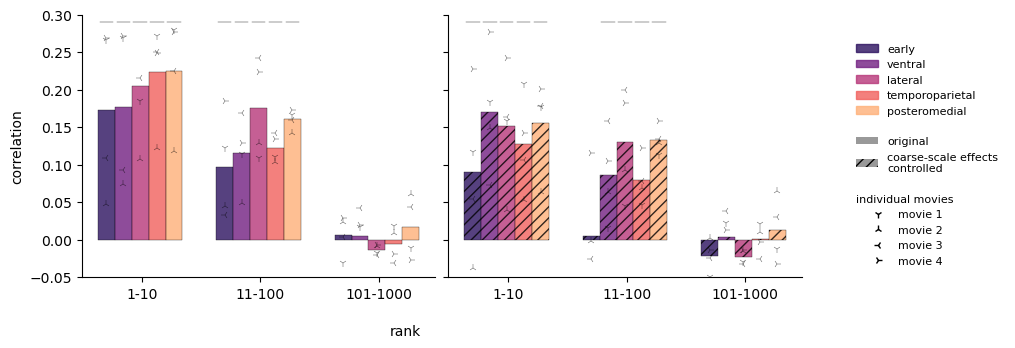

In [43]:
from matplotlib.patches import Rectangle
idm_roi_colors = sns.color_palette("magma", len(rois))
markers = ['1', '2', '3', '4']
movies = ['iteration', 'defeat', 'growth', 'lemonade']  # Add your actual movie names here

def create_nature_figures():
    # Reduced figure width from 12 to 8
    plt.rcParams.update({'figure.figsize': (8, 3)})
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    
    # Reduced spacing parameters
    bar_width = 0.05  # Reduced from 0.08
    decade_spacing = 0.35  # Reduced from 0.45
    roi_spacing = 0.05   # Reduced from 0.09
    line_length = bar_width * 1
    
    def plot_condition(ax, data, significance_data, pattern):
        for d, eigen in enumerate(rank_slices):
            x_base = d * decade_spacing
            for r, roi in enumerate(rois):
                x_pos = x_base + (r * roi_spacing)
                mean_val = np.mean([data[roi][movie][eigen] for movie in movies])
                
                bar = ax.bar(x_pos, mean_val,
                           width=bar_width, color=idm_roi_colors[r],
                           alpha=0.8, edgecolor='black', linewidth=0.3)[0]
                
                if pattern:
                    bar.set_hatch('///')
                
                true_center = bar.get_x() + (bar.get_width() / 2)
                
                # Plot markers using exact bar center
                for n_mov, movie in enumerate(movies):
                    ax.plot(true_center, data[roi][movie][eigen],
                           marker=markers[n_mov], color=idm_roi_colors[r],
                           alpha=0.8, markersize=6,
                           markeredgecolor='black', markeredgewidth=0.3,
                           zorder=3)
                
                if significance_data[roi][eigen] < 0.05:
                    ax.plot([true_center - line_length/2 + 0.005, true_center + line_length/2 - 0.005],
                           [0.29, 0.29],
                           color='#333333', linewidth=0.35,
                           zorder=4)
                    # ax.plot(true_center, 0.29,  # Adjust the y-position as needed
                    #     marker='o',  # Use a circle marker
                    #     color=idm_roi_colors[r],  # Use the same color as the ROI
                    #     markersize=2,  # Adjust size as needed
                    #     zorder=4)
    
    # Plot IDM_PLS
    plot_condition(ax1, behavioral, significance, False)
    #ax1.set_title('$\mathrm{IDM_{PLS}}$', pad=10)
    
    # Plot IDM_PLS|ISC
    plot_condition(ax2, behavioral_isc, significance_isc, True)
    #ax2.set_title('$\mathrm{IDM_{PLS|ISC}}$', pad=10)
    
    # Customize both axes
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(-0.05, 0.3)
        
        # Adjusted x-ticks for new spacing
        ax.set_xticks([0.105, 0.455, 0.805])
        ax.set_xticklabels(['1-10', '11-100', '101-1000'])
    
    ax1.set_ylabel("correlation")
    ax2.set_yticklabels([])
    
    # Add ROI legend with abbreviated labels
    roi_patches = [Rectangle((0,0), 1, 1, color=idm_roi_colors[i], alpha=0.8) 
                  for i in range(len(rois))]
    
    # Create pattern legend
    pattern_patches = [
        Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.8, label='$\mathrm{IDM_{PLS}}$'),
        Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.8, hatch='///', label='$\mathrm{IDM_{PLS|ISC}}$')
    ]
    
    # Create a simplified movie marker legend - one element with a title
    movie_markers = [plt.Line2D([0], [0], marker=markers[i], color='black', 
                             linestyle='', markersize=6) 
                    for i in range(len(movies))]
    
    # Add legends with adjusted position for smaller figure
    fig.legend(roi_patches, ['early', 'ventral', 'lateral', 'temporoparietal', 'posteromedial'], 
              bbox_to_anchor=(1.05, 0.75),
              loc='center left', 
              frameon=False, 
              fontsize=8)
    
    fig.legend(pattern_patches, ['original', 'coarse-scale effects \ncontrolled'],
              bbox_to_anchor=(1.05, 0.5),
              loc='center left',
              frameon=False,
              fontsize=8)
    
    # Add the movie markers legend with a single label
    fig.legend(movie_markers, ["movie 1", "movie 2", "movie 3", "movie 4"],
              bbox_to_anchor=(1.05, 0.25),
              loc='center left',
              frameon=False,
              fontsize=8,
              title="individual movies",
              title_fontsize=8)
    
    fig.text(0.5, -0.1, 'rank', ha='center')
    
    plt.savefig('figure4-magma.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.show()

create_nature_figures()

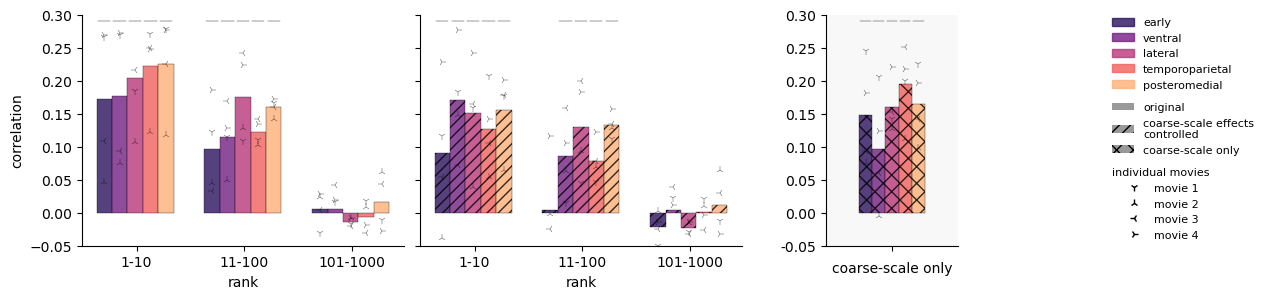

In [24]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

# Assuming these variables are defined in your environment
# rois = ['early', 'ventral', 'lateral', 'temporoparietal', 'posteromedial']
# rank_slices = ['1-10', '11-100', '101-1000']
# movies = ['iteration', 'defeat', 'growth', 'lemonade']

idm_roi_colors = sns.color_palette("magma", len(rois))
markers = ['1', '2', '3', '4']

def create_modified_nature_figures(behavioral, significance, behavioral_isc, significance_isc, 
                                  behavioral_anat, significance_anat):
    # Create figure with custom GridSpec for better control
    plt.rcParams.update({'figure.figsize': (12, 3)})
    
    fig = plt.figure(figsize=(12, 3))
    
    # Create two separate GridSpec objects with reduced spacing
    # First GridSpec for the first two plots (clustered together)
    gs1 = GridSpec(1, 2, left=0.05, right=0.60, wspace=0.05)
    # Second GridSpec for the third plot (separated with a gap)
    gs2 = GridSpec(1, 1, left=0.67, right=0.78)
    
    ax1 = fig.add_subplot(gs1[0, 0])
    ax2 = fig.add_subplot(gs1[0, 1])
    ax3 = fig.add_subplot(gs2[0, 0])
    
    # Add subtle background color to the third plot
    ax3.set_facecolor('#f8f8f8')
    
    # Consistent parameters across all plots
    bar_width = 0.05
    decade_spacing = 0.35
    roi_spacing = 0.05
    line_length = bar_width * 1
    
    def plot_rank_data(ax, data, significance_data, pattern):
        # For first two plots with rank data
        for d, eigen in enumerate(rank_slices):
            x_base = d * decade_spacing
            for r, roi in enumerate(rois):
                x_pos = x_base + (r * roi_spacing)
                mean_val = np.mean([data[roi][movie][eigen] for movie in movies])
                
                bar = ax.bar(x_pos, mean_val,
                          width=bar_width, color=idm_roi_colors[r],
                          alpha=0.8, edgecolor='black', linewidth=0.3)[0]
                
                if pattern:
                    bar.set_hatch('///')
                
                true_center = bar.get_x() + (bar.get_width() / 2)
                
                # Plot markers
                for n_mov, movie in enumerate(movies):
                    ax.plot(true_center, data[roi][movie][eigen],
                          marker=markers[n_mov], color=idm_roi_colors[r],
                          alpha=0.8, markersize=6,
                          markeredgecolor='black', markeredgewidth=0.3,
                          zorder=3)
                
                if significance_data[roi][eigen] < 0.05:
                    ax.plot([true_center - line_length/2 + 0.005, true_center + line_length/2 - 0.005],
                          [0.29, 0.29],
                          color='#333333', linewidth=0.35,
                          zorder=4)
    
    def plot_coarse_data(ax, data, significance_data):
        # For third plot with coarse-scale data
        # Center the entire group of bars
        n_rois = len(rois)
        total_width = (n_rois - 1) * roi_spacing
        start_pos = -total_width / 2  # Start position to center the group
        
        for r, roi in enumerate(rois):
            x_pos = start_pos + (r * roi_spacing)
            mean_val = np.mean([data[roi][movie] for movie in movies])
            
            bar = ax.bar(x_pos, mean_val,
                       width=bar_width, color=idm_roi_colors[r],
                       alpha=0.8, edgecolor='black', linewidth=0.3)[0]
            
            # Use a different pattern
            bar.set_hatch('xx')
            
            true_center = bar.get_x() + (bar.get_width() / 2)
            
            # Plot markers
            for n_mov, movie in enumerate(movies):
                ax.plot(true_center, data[roi][movie],
                       marker=markers[n_mov], color=idm_roi_colors[r],
                       alpha=0.8, markersize=6,
                       markeredgecolor='black', markeredgewidth=0.3,
                       zorder=3)
            
            if significance_data[roi] < 0.05:
                ax.plot([true_center - line_length/2 + 0.005, true_center + line_length/2 - 0.005],
                       [0.29, 0.29],
                       color='#333333', linewidth=0.35,
                       zorder=4)
    
    # Plot the data
    plot_rank_data(ax1, behavioral, significance, pattern=False)
    plot_rank_data(ax2, behavioral_isc, significance_isc, pattern=True)
    plot_coarse_data(ax3, behavioral_anat, significance_anat)
    
    # Configure axes
    for ax in [ax1, ax2, ax3]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(-0.05, 0.3)
    
    # Set x-ticks for first two plots
    for ax in [ax1, ax2]:
        ax.set_xticks([0.105, 0.455, 0.805])
        ax.set_xticklabels(['1-10', '11-100', '101-1000'])
        ax.set_xlabel('rank')
    
    # Set centered x-tick for third plot
    ax3.set_xticks([0])  # Center tick at 0
    ax3.set_xticklabels([''])
    ax3.set_xlabel('coarse-scale only')
    
    # Set appropriate x-limits for third plot to properly center bars
    x_padding = 0.15  # Add padding around the bars
    n_rois = len(rois)
    total_width = (n_rois - 1) * roi_spacing
    ax3.set_xlim(-total_width/2 - x_padding, total_width/2 + x_padding)
    
    # Set y-axis labels
    ax1.set_ylabel("correlation")
    ax2.set_yticklabels([])
    
    # Add y-ticks and labels to the third plot
    ax3.set_yticks(ax1.get_yticks())
    ax3.set_yticklabels([f"{y:.2f}" for y in ax3.get_yticks()])
    
    # Create legend elements
    roi_patches = [Rectangle((0,0), 1, 1, color=idm_roi_colors[i], alpha=0.8) 
                  for i in range(len(rois))]
    
    pattern_patches = [
        Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.8, label='original'),
        Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.8, hatch='///', label='coarse-scale effects \ncontrolled'),
        Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.8, hatch='xx', label='coarse-scale')
    ]
    
    movie_markers = [plt.Line2D([0], [0], marker=markers[i], color='black', 
                             linestyle='', markersize=6) 
                    for i in range(len(movies))]
    
    # Add legends with reduced spacing
    fig.legend(roi_patches, ['early', 'ventral', 'lateral', 'temporoparietal', 'posteromedial'], 
              bbox_to_anchor=(0.90, 0.75),
              loc='center left', 
              frameon=False, 
              fontsize=8)
    
    fig.legend(pattern_patches, ['original', 'coarse-scale effects \ncontrolled', 'coarse-scale only'],
              bbox_to_anchor=(0.90, 0.5),
              loc='center left',
              frameon=False,
              fontsize=8)
    
    fig.legend(movie_markers, ["movie 1", "movie 2", "movie 3", "movie 4"],
              bbox_to_anchor=(0.90, 0.25),
              loc='center left',
              frameon=False,
              fontsize=8,
              title="individual movies",
              title_fontsize=8)
    
    plt.savefig('figure4-isc.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.show()

# Example usage:
create_modified_nature_figures(behavioral, significance, 
                             behavioral_isc, significance_isc, 
                             behavioral_anat, significance_anat)